In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Load, transform and examine the data
data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/StockManagement/SM_data.xlsx', sheet_name='RawDataOperations', parse_dates=True)
data['MonthYear'] = data['MonthYear'].astype('datetime64')

data_stocks = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/StockManagement/SM_data.xlsx', sheet_name='RawDataStocks', parse_dates=True)
data_stocks['MonthYear'] = data_stocks['MonthYear'].astype('datetime64')
data_stocks.fillna(value=0, inplace=True)

In [4]:
#Preferences. Play here!

ABC_V = {'AA': 0.0, 'AB': 0.45, 'BB': 0.65, 'BC': 0.8, 'CC': 0.94} #ABC LEFT cumulative levels dictionary by sales
ABC_Q = {'AA': 0.0, 'AB': 0.04, 'BB': 0.12, 'BC': 0.28, 'CC': 0.56} #ABC LEFT cumulative levels dictionary by quantiles (percentage of items quantity)

FMR_V = {'FF': 0.0, 'FM': 0.45, 'MM': 0.65, 'MR': 0.8, 'RR': 0.94} #FMR LEFT cumulative levels diсtionary by number of orders
FMR_Q = {'FF': 0.0, 'FM': 0.04, 'MM': 0.12, 'MR': 0.28, 'RR': 0.56} #FMR LEFT cumulative levels dictionary by quantiles (percentage of items quantity)

"""
ABC_V = {'A': 0.0, 'B': 0.6, 'C': 0.85}
FMR_V = {'F': 0.0, 'M': 0.6, 'R': 0.85}
"""

"""
ReplenishmentPeriod = {'A': 1.0, 'B': 3.0, 'CC': 6.0} #Replenishment period, months
ReplenishToStock = {'F': True, 'M': True, 'R': False} #Replenish-to-stock in YES-NO terms
SafetyTime = {'F': 1.25, 'M': 0.75, 'R': 0} #Safety time, months
LeadTime = 1 #Leadtime as a constant for all the items. Can be easily changed to a vector of the individual lead times by item
"""

ReplenishmentPeriod = {'AA': 1.0, 'AB': 2.0, 'BB': 3.0, 'BC': 4.5, 'CC': 6.0} #Replenishment period, months
ReplenishToStock = {'FF': True, 'FM': True, 'MM': True, 'MR': False, 'RR': False} #Replenish-to-stock in YES-NO terms
SafetyTime = {'FF': 1.25, 'FM': 1.0, 'MM': 0.75, 'MR': 0, 'RR': 0} #Safety time, months
LeadTime = 1 #Leadtime as a constant for all the items. Can be easily changed to a vector of the individual lead times by item

pd.options.display.float_format = '{:,.2f}'.format #Display two signs after dot, separate thousands by comma
ABC = ABC_Q #Our ABC is "Volume ABC". Change to ABC_Q for "Quantile ABC"
FMR = FMR_Q #Our FMR is "Volume FMR". Change to FMR_Q for "Quantile FMR"

In [5]:
#ABC
sales_sum = data['Sum'].agg(np.sum)
data_ABC = data.groupby('ItemId')[['Sum']].agg('sum')
data_ABC['KABC'] = data_ABC['Sum'] / sales_sum
data_ABC.sort_values('KABC', ascending=False, inplace=True)
data_ABC['CumKABC'] = data_ABC['KABC'].cumsum()

#Classification by choosen ABC classification method
if ABC != ABC_Q:
  for ABC_class in ABC:
    data_ABC.loc[data_ABC['CumKABC'] >= ABC[ABC_class], 'ABC_class'] = ABC_class
elif ABC == ABC_Q:
  for ABC_class in ABC:
    data_ABC.loc[data_ABC['CumKABC'] >= np.quantile(data_ABC['CumKABC'], ABC[ABC_class]), 'ABC_class'] = ABC_class

In [6]:
#FMR
sales_rows = data['ItemId'].count()
data_FMR = data.groupby('ItemId')[['OrderId', 'Quantity']].agg({'OrderId':'count', 'Quantity': 'mean'})
data_FMR.columns = ['NumberOfOrders', 'AvgQuantityPerOrder']
data_FMR['KFMR'] = data_FMR['NumberOfOrders'] / sales_rows
data_FMR.sort_values('KFMR', ascending=False, inplace=True)
data_FMR['CumKFMR'] = data_FMR['KFMR'].cumsum()

#Classification by choosen FMR classification method
if FMR != FMR_Q:
  for FMR_class in FMR:
    data_FMR.loc[data_FMR['CumKFMR'] >= FMR[FMR_class], 'FMR_class'] = FMR_class
elif FMR == FMR_Q:
  for FMR_class in FMR_Q:
    data_FMR.loc[data_FMR['CumKFMR'] >= np.quantile(data_FMR['CumKFMR'], FMR[FMR_class]), 'FMR_class'] = FMR_class

In [7]:
#Manual FMR correction
#data_FMR.loc[(data_FMR['NumberOfOrders'] >= 4) & (data_FMR['NumberOfOrders'] <= 5), 'FMR_class'] = 'MM'

In [8]:
data_ABC_FMR = data_ABC[['Sum', 'ABC_class']].merge(data_FMR[['NumberOfOrders', 'AvgQuantityPerOrder', 'FMR_class']] , on='ItemId')

In [9]:
#Sales by ABS classes
data_ABC_FMR.groupby('ABC_class')[['Sum']].agg(['count', 'sum'])

Sum              
          count           sum
ABC_class                    
AA           88 49,328,754.87
AB          174 27,525,579.57
BB          348 23,407,509.54
BC          609 15,393,277.11
CC          958  6,361,897.80

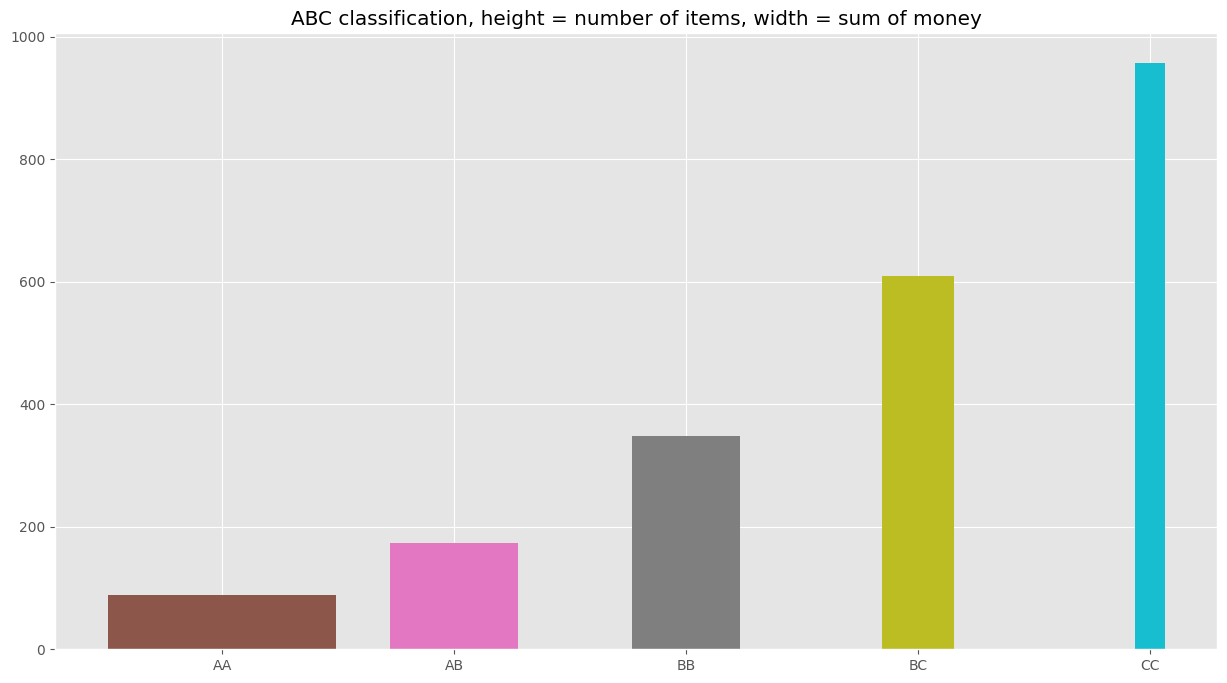

In [10]:
#Show the beauty
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(15, 8))
ax.set_title('ABC classification, height = number of items, width = sum of money')
ax.bar(list(ABC), data_ABC['ABC_class'].value_counts().sort_index(), width=data_ABC.groupby('ABC_class')['Sum'].sum() / 5e7, color=['tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']);

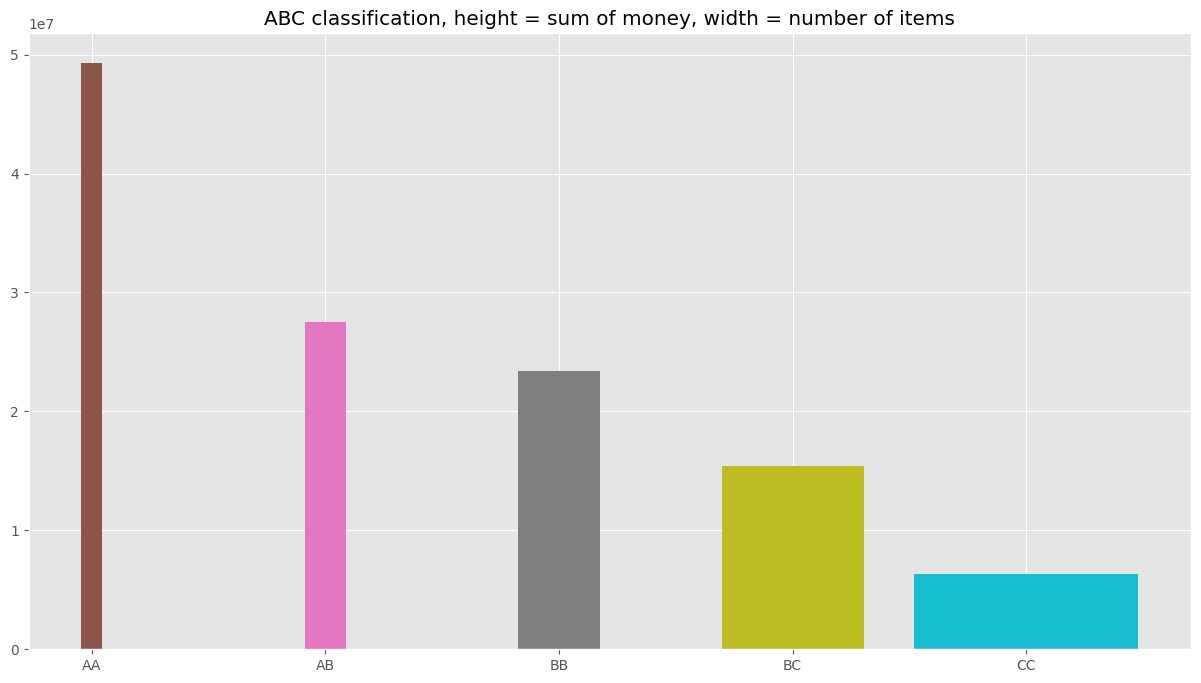

In [11]:
#Show the beauty
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(15, 8))
ax.set_title('ABC classification, height = sum of money, width = number of items')
ax.bar(list(ABC), data_ABC.groupby('ABC_class')['Sum'].sum(), width=data_ABC['ABC_class'].value_counts().sort_index() / 1e3, color=['tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']);

In [12]:
#Quantity and Sales by FMR class
data_ABC_FMR.groupby('FMR_class')[['Sum']].agg(['count', 'sum'])

Sum              
          count           sum
FMR_class                    
FF           88 42,717,765.51
FM          174 28,012,443.67
MM          348 22,534,136.22
MR          609 17,997,287.49
RR          958 10,755,386.00

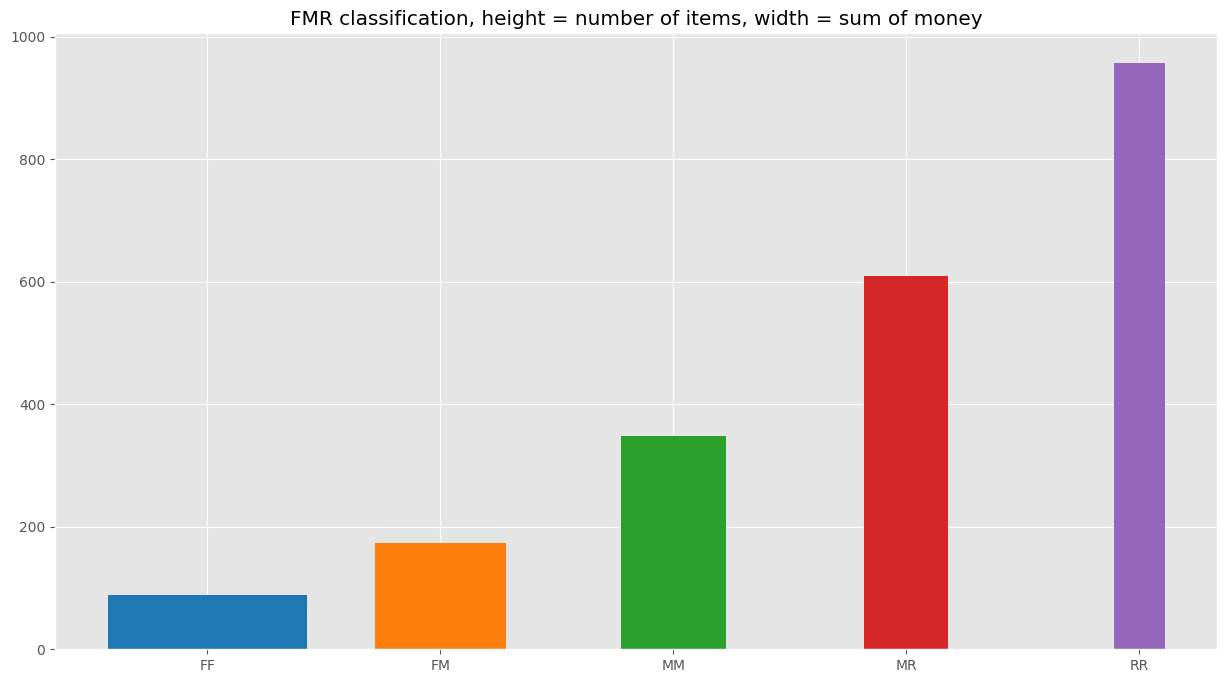

In [13]:
#Show the beauty
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(15, 8))
ax.set_title('FMR classification, height = number of items, width = sum of money')
ax.bar(list(FMR), data_FMR['FMR_class'].value_counts().sort_index(), width=data_ABC_FMR.groupby('FMR_class')['Sum'].sum() / 5e7, color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']);

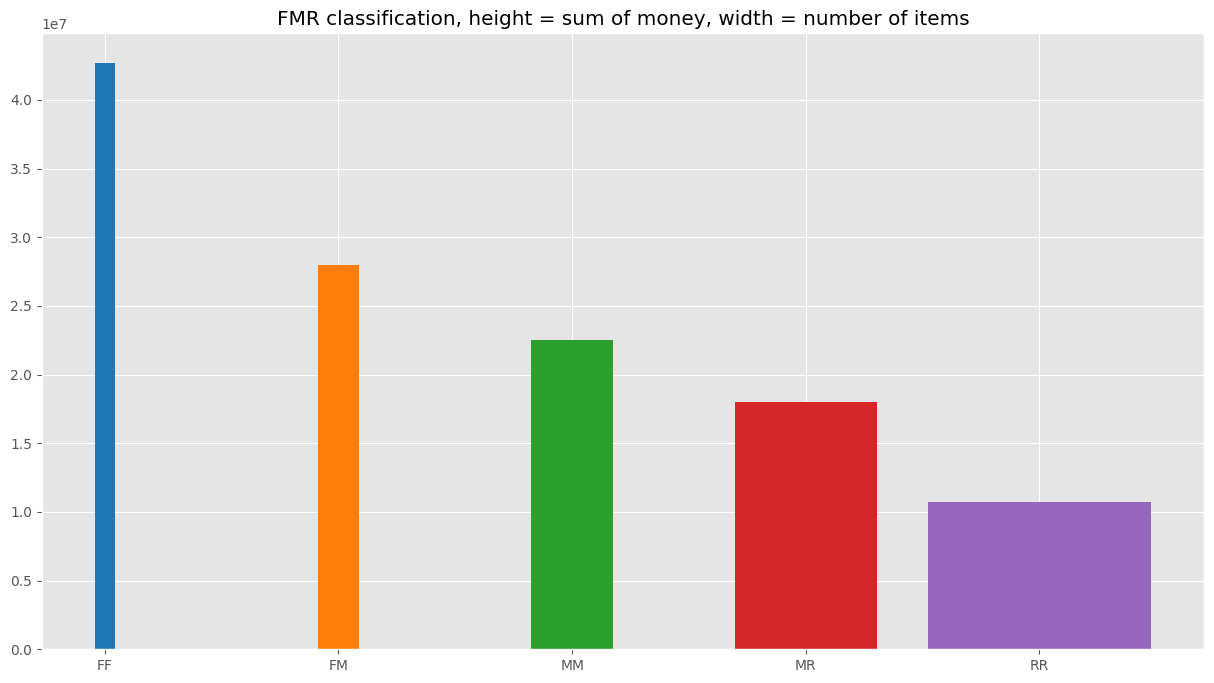

In [14]:
#Show the beauty
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(15, 8))
ax.set_title('FMR classification, height = sum of money, width = number of items')
ax.bar(list(FMR), data_ABC_FMR.groupby('FMR_class')['Sum'].sum(), width=data_FMR['FMR_class'].value_counts().sort_index() / 1e3, color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']);

In [15]:
#Calculate avg price
data_ABC_FMR['Price'] = data_ABC_FMR['Sum'] / (data_ABC_FMR['NumberOfOrders'] * data_ABC_FMR['AvgQuantityPerOrder'])

#Replenish to stock strategy
for FMR_class in ReplenishToStock:
    data_ABC_FMR.loc[data_ABC_FMR['FMR_class'] == FMR_class, 'ReplenishToStock'] = ReplenishToStock[FMR_class]
    
#Safety time
for FMR_class in SafetyTime:
    data_ABC_FMR.loc[data_ABC_FMR['FMR_class'] == FMR_class, 'SafetyTime'] = SafetyTime[FMR_class]
    
#Total lead time
data_ABC_FMR['TotalLeadTime'] = data_ABC_FMR['ReplenishToStock'] * (data_ABC_FMR['SafetyTime'] + LeadTime)

#Replenishment period
for ABC_class in ReplenishmentPeriod:
    data_ABC_FMR.loc[data_ABC_FMR['ABC_class'] == ABC_class, 'ReplenishmentPeriod'] = ReplenishmentPeriod[ABC_class]
    
#Target stock period
data_ABC_FMR['TargetStockPeriod'] = data_ABC_FMR['SafetyTime'] + data_ABC_FMR['ReplenishmentPeriod'] / 2

#Target stock
data_ABC_FMR['TargetStock'] = (data_ABC_FMR['NumberOfOrders'] / 12) * data_ABC_FMR['AvgQuantityPerOrder'] * data_ABC_FMR['TargetStockPeriod']

#Target stock sum
data_ABC_FMR['TargetStockSum'] = data_ABC_FMR['TargetStock'] * data_ABC_FMR['Price']

#Target average orders in transit
data_ABC_FMR['TargetAvgOrdersInTransit'] = data_ABC_FMR['ReplenishToStock'] / data_ABC_FMR['ReplenishmentPeriod']

#Target average in transit
data_ABC_FMR['TargetAvgInTransit'] = (data_ABC_FMR['NumberOfOrders'] / 12) * data_ABC_FMR['AvgQuantityPerOrder'] * data_ABC_FMR['TargetAvgOrdersInTransit']

#Target average sum in transit
data_ABC_FMR['TargetAvgSumInTransit'] = data_ABC_FMR['TargetAvgInTransit'] * data_ABC_FMR['Price']

#Target average sum total in transit
data_ABC_FMR['TargetAvgSumTotal'] = data_ABC_FMR['TargetStockSum'] + data_ABC_FMR['TargetAvgSumInTransit']

In [16]:
#Prepare and connect Stocks data to our dataset

stocks_dec22 = data_stocks.loc[data_stocks['MonthYear'] == '2022-12-01', ['ItemId', 'Stock']]
stocks_dec22.columns = ['ItemId', 'StocksDec22']

stocks_avg22 = data_stocks.groupby('ItemId', as_index=False)[['Stock']].agg('mean')
stocks_avg22.columns = ['ItemId', 'StocksAvg22']

data_ABC_FMR = data_ABC_FMR.merge(stocks_dec22, on='ItemId').merge(stocks_avg22, on='ItemId')

data_ABC_FMR['StocksSumDec22'] = data_ABC_FMR['StocksDec22'] * data_ABC_FMR['Price']
data_ABC_FMR['StocksSumAvg22'] = data_ABC_FMR['StocksAvg22'] * data_ABC_FMR['Price']

In [17]:
#Create a pivot table with outcome data

data_ABC_FMR_pivot = data_ABC_FMR.reset_index().pivot_table(index=['FMR_class', 'ABC_class'],
                                                            values=['ItemId', 'Sum', 'TargetAvgSumTotal', 'StocksSumDec22', 'StocksSumAvg22'],
                                                            aggfunc={'ItemId': 'count', 'Sum': 'sum', 'TargetAvgSumTotal': 'sum', 'StocksSumDec22': 'sum', 'StocksSumAvg22': 'sum'})
data_ABC_FMR_pivot.columns = ['ItemId', 'StockSumAvg22', 'StockSumDec22', 'SalesSumTotal22', 'StockSumAvgTarget']
data_ABC_FMR_pivot.reset_index(inplace=True)

In [18]:
#Show the pivot outcome

data_ABC_FMR_pivot.set_index(['FMR_class', 'ABC_class'])

ItemId  StockSumAvg22  StockSumDec22  SalesSumTotal22  \
FMR_class ABC_class                                                          
FF        AA             54  15,346,600.47   4,468,762.14    36,494,043.43   
          AB             33   2,236,718.54   1,147,382.49     6,128,737.35   
          BB              1      53,566.97      30,925.26        94,984.73   
FM        AA             28   5,385,138.29   3,016,002.06    10,809,084.55   
          AB             77   5,394,356.38   3,469,798.94    12,174,142.10   
          BB             64   1,842,503.72   1,307,051.79     4,932,774.59   
          BC              2      37,971.82      12,790.88        70,923.43   
          CC              3      15,664.72      13,359.20        25,519.00   
MM        AA              5     887,895.89     441,151.77     1,758,437.20   
          AB             43   2,719,522.54   2,103,070.27     6,216,003.07   
          BB            151   4,483,896.64   3,107,494.94    10,381,859.52   
          BC            131   1,830,104.19   1,375,709.61     3,822,872.62   
          CC             14      40,130.98      26,519.61       126,597.21   
MR        AA              1      39,617.78           0.00       267,189.69   
          AB             15   1,510,542.60     942,584.86     2,317,285.66   
          BB             91   4,449,554.12   2,885,614.01     5,654,901.19   
          BC            253   4,525,143.18   2,940,387.17     6,385,115.69   
          CC            164   1,376,523.29     996,139.12     1,495,181.94   
RR        AB              2     141,087.47      22,221.53       215,652.72   
          BB             14   1,025,741.18     690,577.06       865,464.38   
          BC            115   2,805,386.89   1,983,594.03     2,585,585.00   
          CC            383   4,038,748.59   3,591,340.98     2,291,060.25   

                    StockSumAvgTarget  
FMR_class ABC_class                    
FF        AA             8,363,218.29  
          AB             1,404,502.31  
          BB                24,405.80  
FM        AA             2,251,892.61  
          AB             2,536,279.60  
          BB             1,164,682.89  
          BC                20,521.83  
          CC                 8,860.76  
MM        AA               329,706.98  
          AB             1,165,500.58  
          BB             2,234,983.65  
          BC             1,026,512.09  
          CC                41,319.92  
MR        AA                11,132.90  
          AB               193,107.14  
          BB               706,862.65  
          BC             1,197,209.19  
          CC               373,795.49  
RR        AB                17,971.06  
          BB               108,183.05  
          BC               484,797.19  
          CC               572,765.06

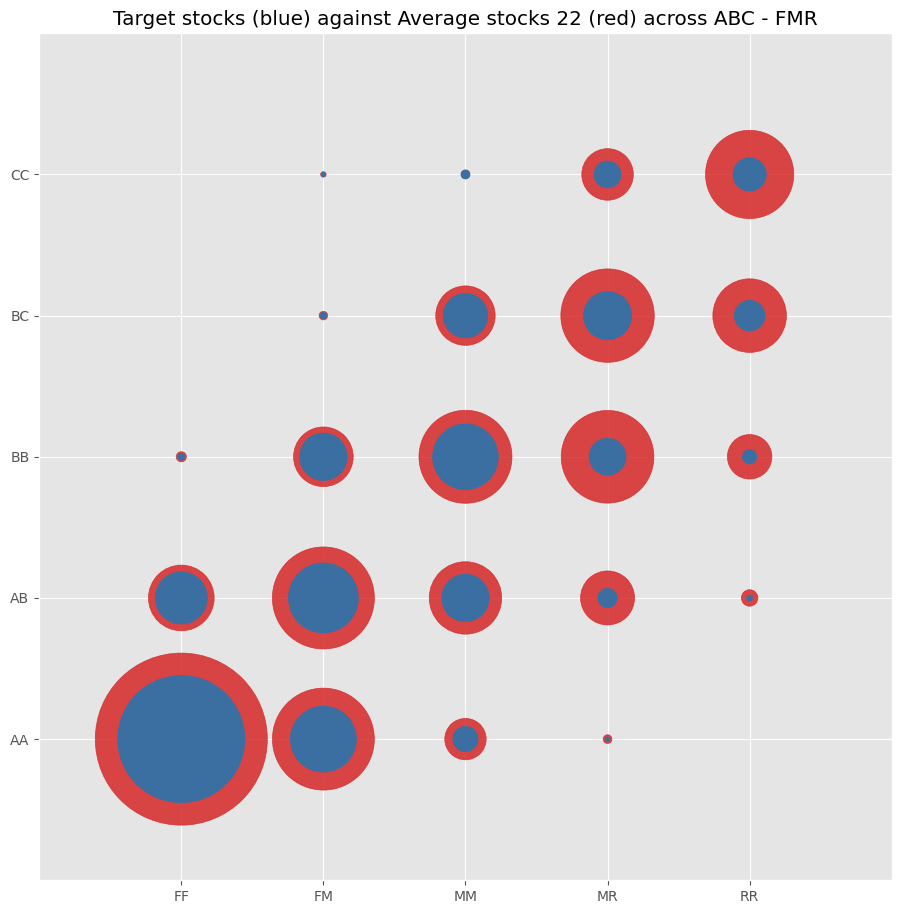

In [19]:
#Show the pivot outcome as a figure

plt.style.use('ggplot')
scale = 1e3 #Scale the circles
alpha = 0.85 #Opacity for the circles if you need it
fig, ax = plt.subplots(figsize=(11, 11))
ax.set_title('Target stocks (blue) against Average stocks 22 (red) across ABC - FMR')
ax.set_xmargin(0.25)
ax.set_ymargin(0.25)
ax.scatter(data_ABC_FMR_pivot['FMR_class'], data_ABC_FMR_pivot['ABC_class'], s=list(data_ABC_FMR_pivot['StockSumAvg22'] / scale), label='Average stocks 22', alpha=alpha, c='tab:red');
ax.scatter(data_ABC_FMR_pivot['FMR_class'], data_ABC_FMR_pivot['ABC_class'], s=list(data_ABC_FMR_pivot['StockSumAvgTarget'] / scale), label='Target stocks', alpha=alpha, c='tab:blue');